In [1]:
!pip install ucimlrepo shap lightgbm imbalanced-learn

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# For reproducibility!
import numpy as np
import random

SEED = 51
np.random.seed(SEED)
random.seed(SEED)

## **College students retention analysis**

*Access to quality education is a fundamental right, and governments worldwide strive to ensure every child's enrollment and completion of their schooling. However, dropout rates in schools remain a persistent challenge, often influenced by various social, economic, and demographic factors. In an effort to address this issue, the Government of Gujarat has recognized the need for a comprehensive analysis of dropout patterns at the school level. By understanding the underlying causes and identifying vulnerable groups, the government aims to formulate targeted interventions that can significantly reduce dropout rates.* Reference: [Student Dropout Analysis for School Education](https://www.kaggle.com/code/jeevabharathis/student-dropout-analysis-for-school-education)

### **1. Exploratory Data Analysis & Data Preprocessing**

1.1 **Exploratory Data Analysis**
- Visualization of data distribution across features is critical for understanding the dataset. The correlation between features and the target variable will be used as an indicator of the feature's impact on the target.

1.2 **Pre-processing**
- As suggested by [Efficient BackProp](https://doi.org/10.1007/978-3-642-35289-8_3) (LeCun, Y.A, et al.), standardizing features can improve the performance of the learning algorithm.

In [4]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

In [5]:
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697)

X = predict_students_dropout_and_academic_success.data.features
y = predict_students_dropout_and_academic_success.data.targets
class_column = "Target"

df = X.copy()
df[class_column] = y

In [6]:
df.shape

(4424, 37)

#### **1.1 Exploratory Analysis**

The data has no missing values, but there is an imbalance in the target classes. Features with high absolute correlation to the target have more influence on the predictions. The EDA indicates that **early good performance** and the **possibility of paying college fees** are more influential in the student situation. **Gender** bias should not significantly influence the predictions, nor should **age**, as the magnitude of their correlations is small.

In [7]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

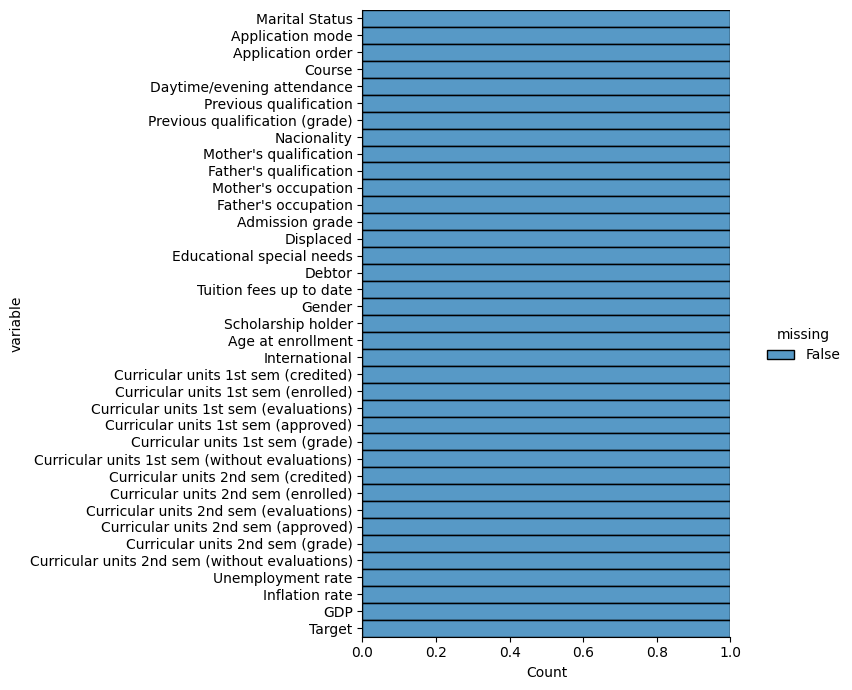

In [8]:
sns.displot(
    data=df.isnull().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    height=7,
    aspect=1.1
)

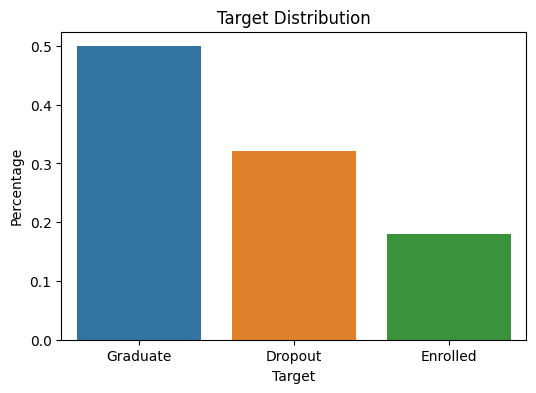

In [9]:
target_counts = df[class_column].value_counts(normalize=True)

df_counts = pd.DataFrame({
    class_column: target_counts.index,
    "Percentage": target_counts.values
})

plt.figure(figsize=(6, 4))
barplot = sns.barplot(x=class_column, y="Percentage", data=df_counts)
plt.title("Target Distribution")
plt.show()

In [10]:
df["Target"].value_counts(normalize=True)

Graduate    0.499322
Dropout     0.321203
Enrolled    0.179476
Name: Target, dtype: float64

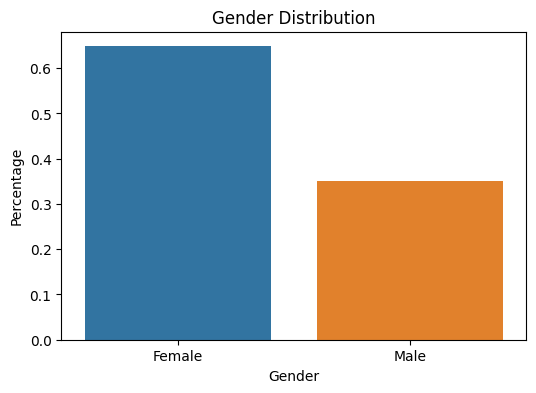

In [11]:
gender_counts = X["Gender"].value_counts(normalize=True)

df_counts = pd.DataFrame({
    "Gender": gender_counts.index,
    "Percentage": gender_counts.values
})

df_counts["Gender"] = df_counts["Gender"].map(lambda x: "Male" if x else "Female")

plt.figure(figsize=(6, 4))
barplot = sns.barplot(x="Gender", y="Percentage", data=df_counts)
plt.title("Gender Distribution")
plt.show()

In [12]:
df_encoded = df.copy()

target_mapping = {
    "Dropout": 0,
    "Enrolled": 1,
    "Graduate": 2
}

reverse_mapping = lambda value: next(key for key, val in target_mapping.items() if val == value)

df_encoded[class_column] = df_encoded[class_column].map(target_mapping)
df_encoded.corr()[class_column].sort_values(ascending=False)

Target                                            1.000000
Curricular units 2nd sem (approved)               0.624157
Curricular units 2nd sem (grade)                  0.566827
Curricular units 1st sem (approved)               0.529123
Curricular units 1st sem (grade)                  0.485207
Tuition fees up to date                           0.409827
Scholarship holder                                0.297595
Curricular units 2nd sem (enrolled)               0.175847
Curricular units 1st sem (enrolled)               0.155974
Admission grade                                   0.120889
Displaced                                         0.113986
Previous qualification (grade)                    0.103764
Curricular units 2nd sem (evaluations)            0.092721
Application order                                 0.089791
Daytime/evening attendance                        0.075107
Curricular units 2nd sem (credited)               0.054004
Curricular units 1st sem (credited)               0.0481

<Axes: xlabel='Curricular units 2nd sem (approved)', ylabel='Count'>

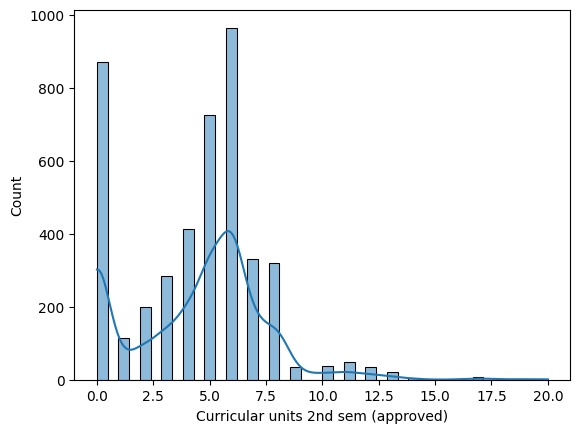

In [13]:
sns.histplot(df, x="Curricular units 2nd sem (approved)", kde=True)

<Axes: xlabel='Curricular units 2nd sem (grade)', ylabel='Count'>

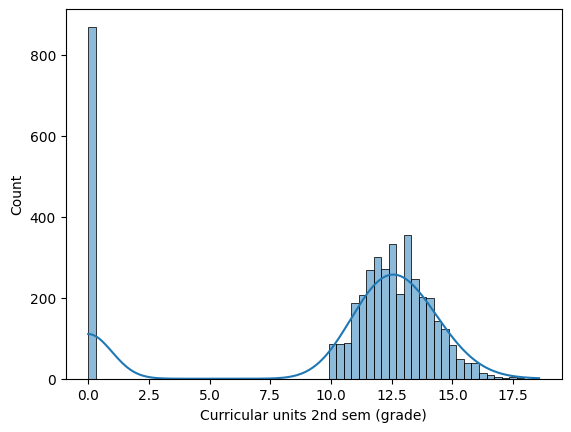

In [14]:
sns.histplot(df, x="Curricular units 2nd sem (grade)", kde=True)

#### **1.2 Pre-processing**

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [16]:
scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

y[class_column] = y[class_column].map(target_mapping)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, np.ravel(y), test_size=0.2, stratify=np.ravel(y))

### **2. Classification and Model Explanation**

2.1 **Feature Selection and Model Interpretability**
- Feature selection will be conducted using Random Forest, focusing on identifying crucial features through Shapley values-based analysis.
- The interpretability of the model is paramount, ensuring transparency and comprehensibility in the decision-making process of unseen data.

2.2 **Model Training**
- An XGBoost model is trained to predict the probability of students discontinuing their college education or having academic success continuing or graduating, with a subsequent analysis of its performance.

2.3 **Model Reliability**
- The model's reliability is rigorously evaluated across different scenarios, determining its robustness and consistency, essential for real-world applicability.

2.4 **Balanced Analysis**
- The final step involves reanalyzing the XGBoost model with a balanced dataset, achieved through over and under sampling, to assess its performance and derive insights.

#### **2.1 Feature Selection and Explicability**

2.1.1 **Feature importance based on mean decrease in impurity**

* This feature importances are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

      Impurity-based feature importances can be misleading for high cardinality features (many unique values).
      Trying another technique is always good for validation.

2.1.2 **Shapley values**

* Shapely values will be used to better understand the decision-making process of predictions for different classes.

2.1.3 **Dicussion**

* Decision-making explicability.

###### 2.1.1 Random Forest

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [19]:
clf_rf = RandomForestClassifier(n_estimators=100)
clf_rf.fit(X_train, y_train)

y_pred = clf_rf.predict(X_test)

print(f"Random Forest accuracy: {accuracy_score(y_test, y_pred)}")

Random Forest accuracy: 0.752542372881356


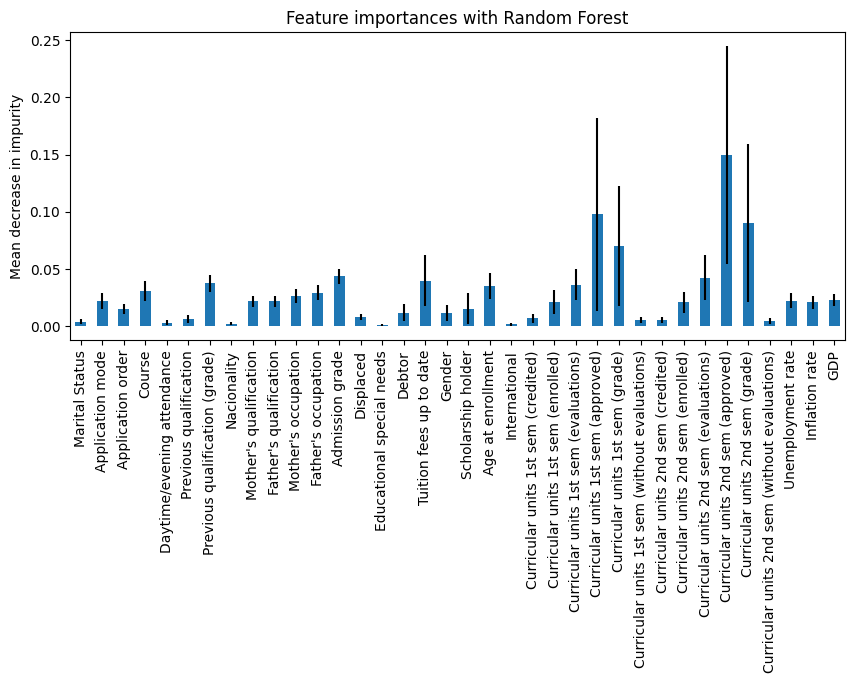

In [20]:
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_], axis=0)
feature_importances = pd.Series(clf_rf.feature_importances_, index=X.columns)

fig, ax = plt.subplots(figsize=(10, 4))
feature_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances with Random Forest")
ax.set_ylabel("Mean decrease in impurity")
plt.show()

In [21]:
# features with low impact on the target
cols_to_drop = [
    "Nacionality",
    "Mother's qualification",
    "Father's qualification",
    "Educational special needs",
    "International",
    "Curricular units 1st sem (without evaluations)",
    "Unemployment rate",
    "Inflation rate"]

In [22]:
X_train = X_train.drop(cols_to_drop, axis=1)
X_test = X_test.drop(cols_to_drop, axis=1)

###### 2.1.2 Shapley Values

In this section, a Light Gradient-Boosting Machine is trained and its decision-making process is analyzed with SHAP decisions plots for correct and incorrect predictions.

In [23]:
import shap
import lightgbm as lgb

In [24]:
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

params = {
    "learning_rate": 0.1,
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "num_class": 3,
    "boost_from_average": True,
    "verbose": 0
}

clf_lgb = lgb.train(
    params,
    train_set=d_train,
    num_boost_round=10000,
    valid_sets=[d_test],
    callbacks=([lgb.early_stopping(stopping_rounds=50)]),
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	valid_0's multi_logloss: 0.548066


In [25]:
y_pred = clf_lgb.predict(X_test)
y_pred

array([[0.21356647, 0.47540129, 0.31103224],
       [0.99553658, 0.00315702, 0.0013064 ],
       [0.15923725, 0.57549263, 0.26527012],
       ...,
       [0.03878459, 0.14043627, 0.82077914],
       [0.73868319, 0.25489072, 0.00642608],
       [0.22486332, 0.64709015, 0.12804652]])

In [26]:
explainer = shap.TreeExplainer(clf_lgb)
shap_values = explainer.shap_values(X_test)

In [27]:
y_pred = np.argmax(clf_lgb.predict(X_test), axis=1)
y_test_series = pd.Series(y_test)

In [28]:
correct_indices = y_test_series[y_test_series == y_pred].index
incorrect_indices = y_test_series[y_test_series != y_pred].index

shap_values_correct = explainer.shap_values(X_test.iloc[correct_indices])
shap_values_incorrect = explainer.shap_values(X_test.iloc[incorrect_indices])

SHAP decision plots show how complex models make decisions. A decision plot can reveal how predictions change across a set of feature values.

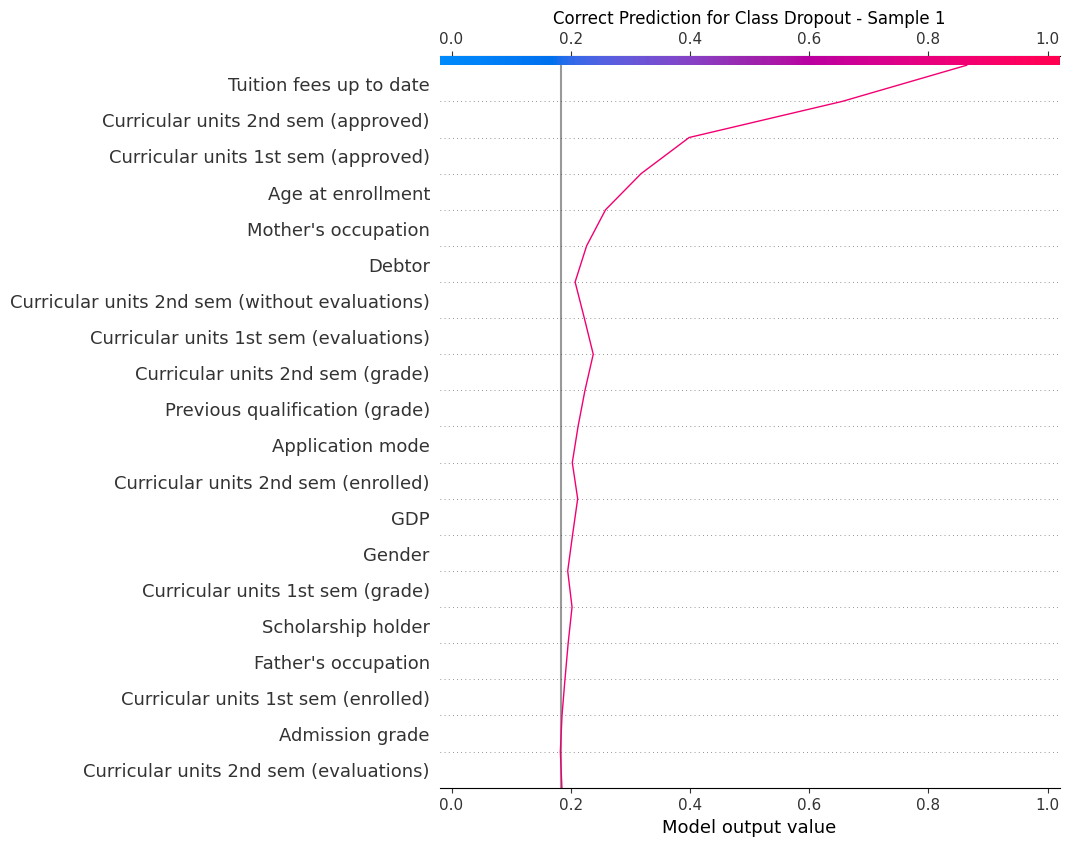

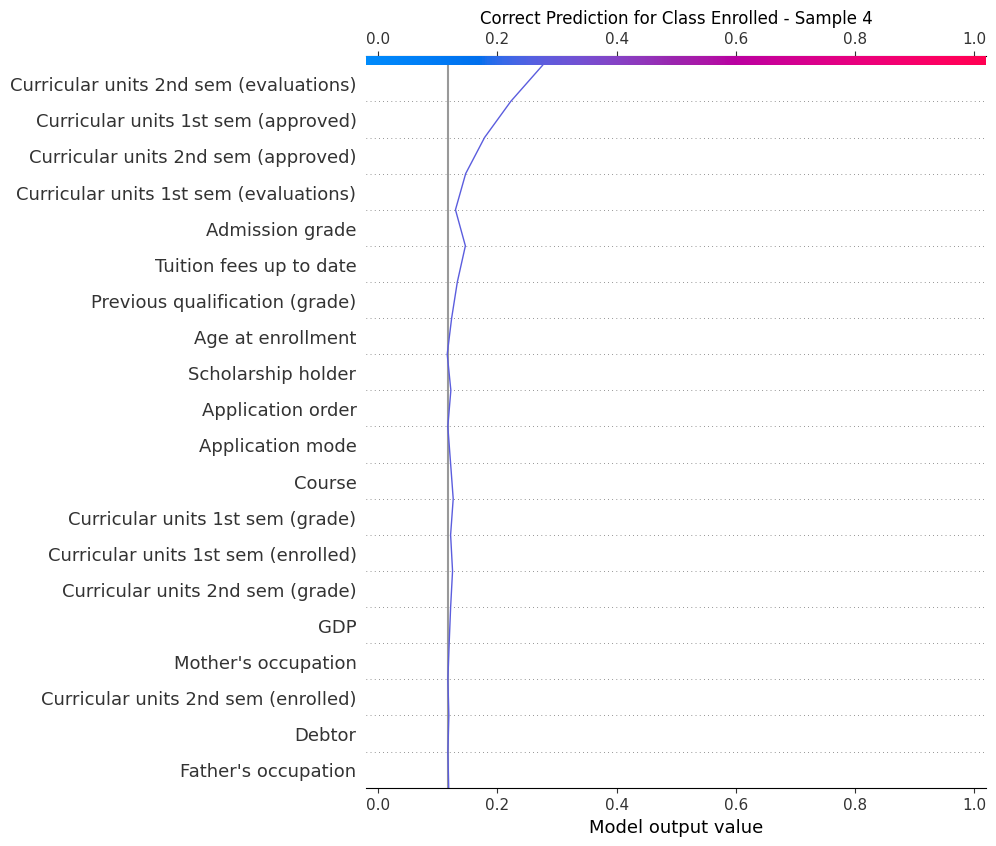

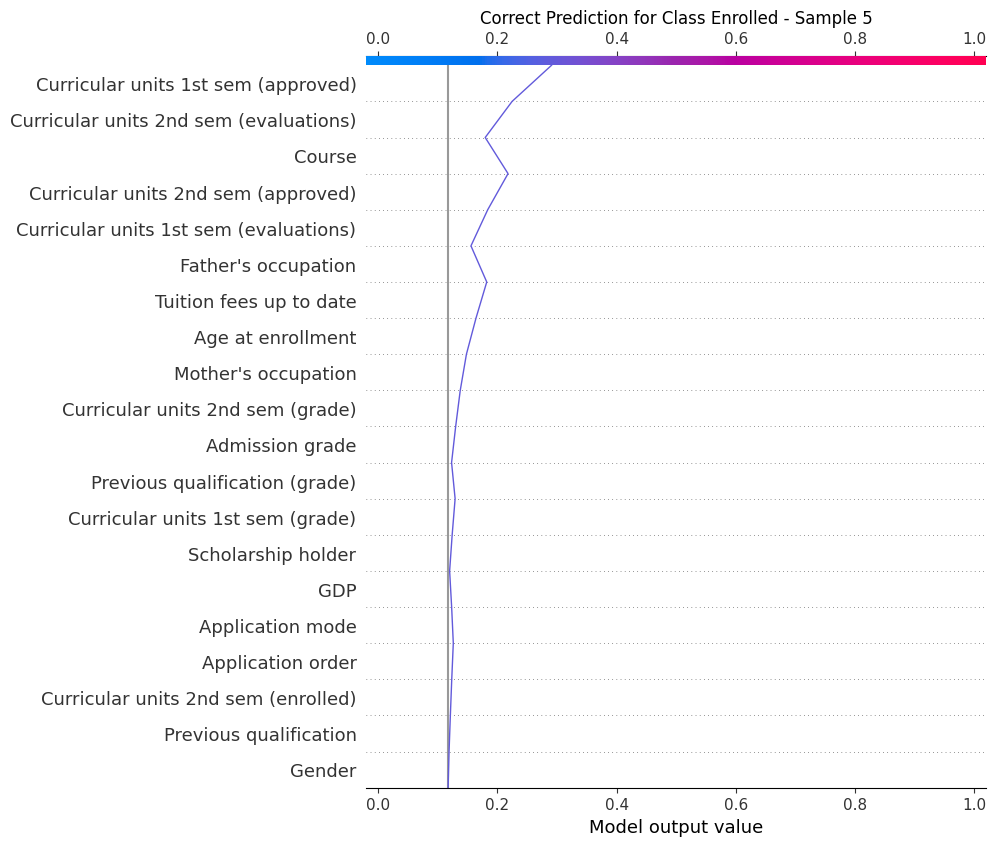

In [29]:
# decision plots for 3 correct predictions
for i in range(3):
  actual_class = correct_indices[i]
  pred_class = y_test[actual_class]

  shap.decision_plot(
      explainer.expected_value[pred_class],
      shap_values_correct[pred_class][i],
      feature_names=X_test.columns.tolist(),
      title=f"Correct Prediction for Class {reverse_mapping(pred_class)} - Sample {actual_class}",
      link="logit"
  )

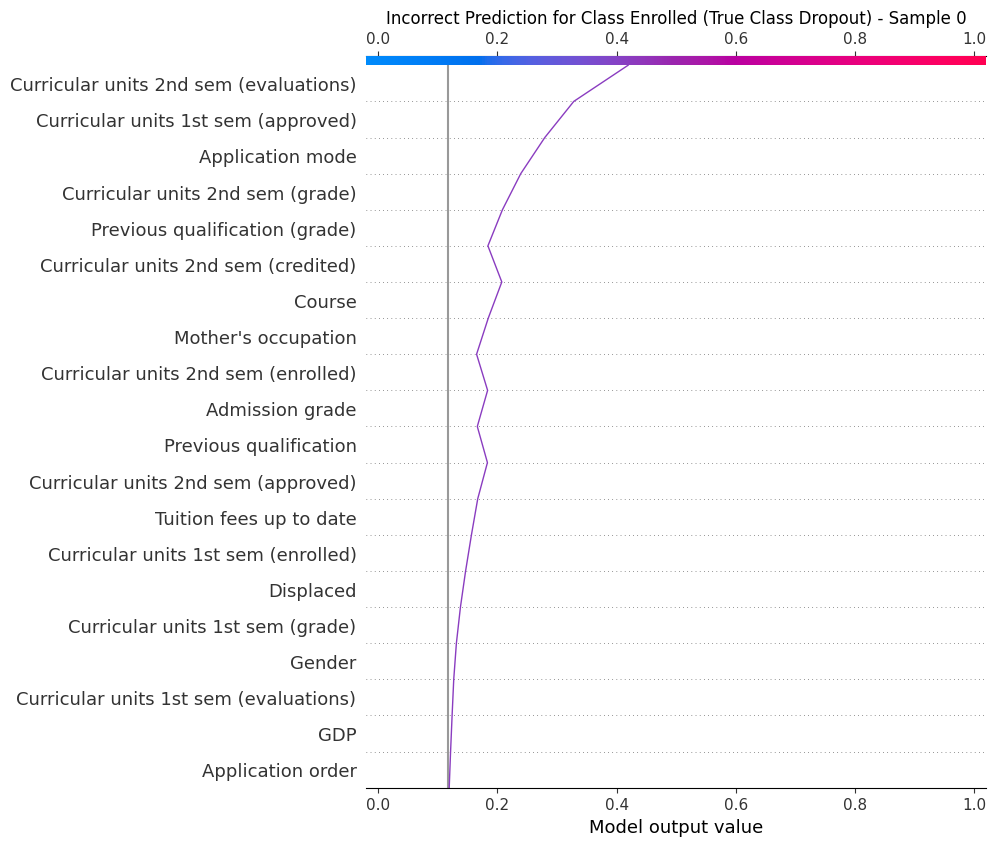

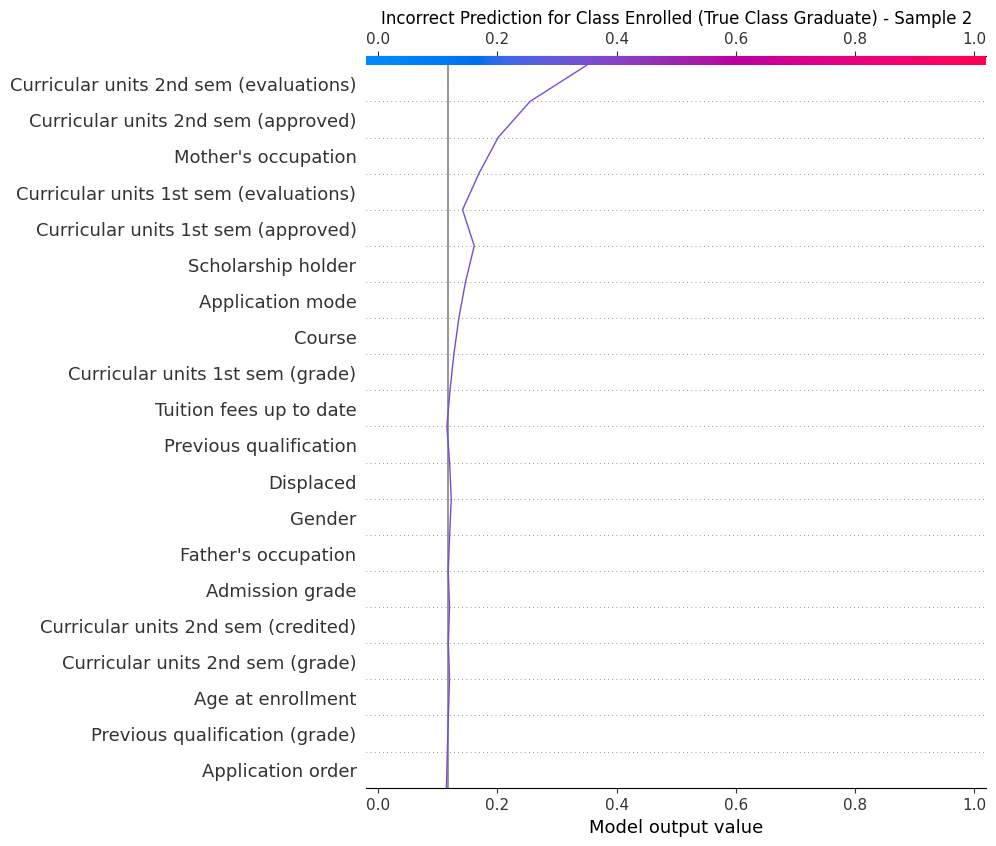

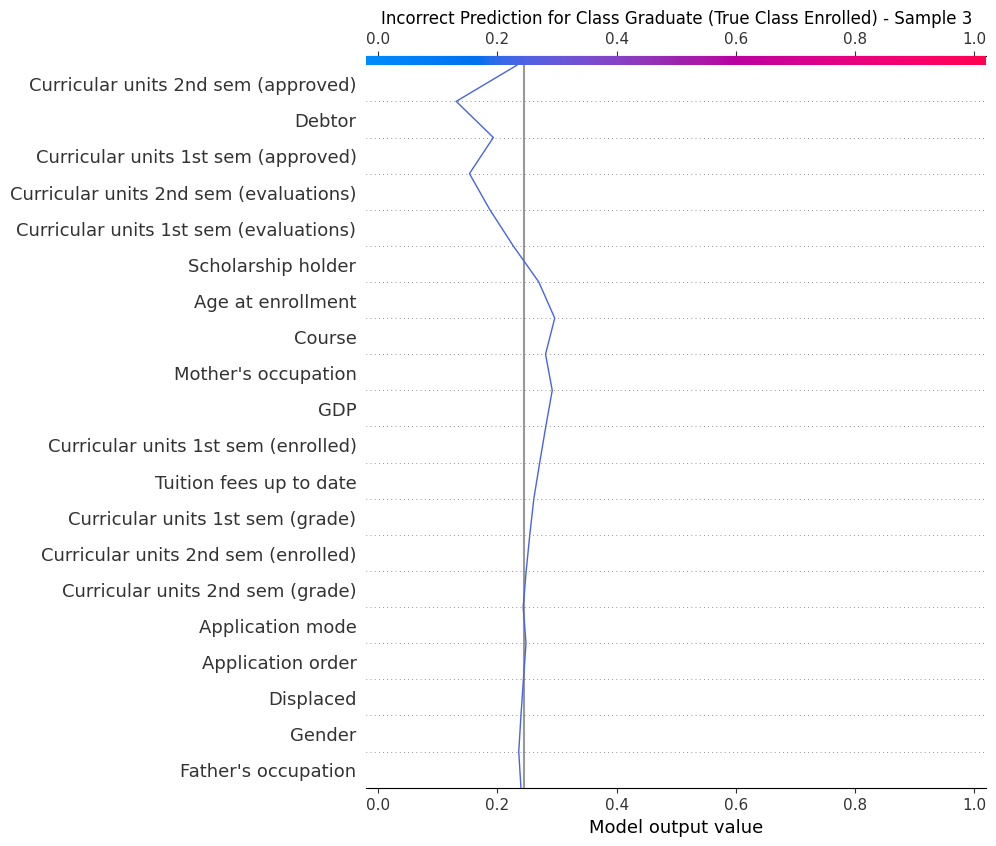

In [30]:
# decision plots for 3 incorrect predictions
for i in range(3):
  pred_class = y_pred[incorrect_indices[i]]
  actual_class = y_test[incorrect_indices[i]]

  shap.decision_plot(
      explainer.expected_value[pred_class],
      shap_values_incorrect[pred_class][i],
      feature_names=X_test.columns.tolist(),
      title=f"Incorrect Prediction for Class {reverse_mapping(pred_class)} (True Class {reverse_mapping(actual_class)}) - Sample {incorrect_indices[i]}",
      link="logit"
  )

###### 2.1.3 Explanation

The analysis suggests that a student's **academic achievements** and their **financial situation** are key predictors of university retention. **Performance in coursework** and the ability to **pay tuition** emerge as the most significant factors. Meanwhile, demographic attributes like **gender** and the **age** at which students begin their university journey are subtly associated with their persistence in their studies. Essentially, academic success and economic stability are critical in understanding dropout trends.

#### **2.2 XGBoost training**

In [31]:
import xgboost as xgb

In [32]:
model = xgb.XGBClassifier(objective='multi:softprob', num_class=3)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"XGBoost accuracy: {accuracy_score(y_test, y_pred)}")

XGBoost accuracy: 0.7762711864406779


#### **2.3 Model reliability**

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score

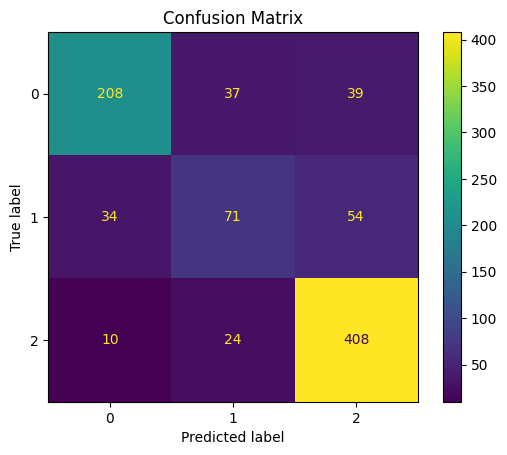

In [34]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [35]:
false_positives = cm.sum(axis=0) - np.diag(cm)
false_negatives = cm.sum(axis=1) - np.diag(cm)

true_positives = np.diag(cm)
true_negatives = cm.sum() - (cm.sum(axis=0) + cm.sum(axis=1) - np.diag(cm))

tpr = true_positives / (true_positives + false_negatives)
tnr = true_negatives / (true_negatives + false_positives)
fnr = false_negatives / (false_negatives + true_positives)
fpr = false_positives / (false_positives + true_negatives)

metrics = {
    reverse_mapping(i): {
        "FPR": fpr[i],
        "FNR": fnr[i],
        "TPR": tpr[i],
        "TNR": tnr[i]
    } for i in range(len(false_positives))
}

**How well are the predictions?**

As the main goal is to predict dropouts probability, this model does it fine.

In [36]:
precisions = precision_score(y_test, y_pred, average=None)
print("\n".join([f"How well is the {reverse_mapping(i)} prediction? -> {precision}" for i, precision in enumerate(precisions)]))

How well is the Dropout prediction? -> 0.8253968253968254
How well is the Enrolled prediction? -> 0.5378787878787878
How well is the Graduate prediction? -> 0.8143712574850299


**How often the predictions fails?**

In [37]:
print("\n".join([f"How often the {classe} prediction fails? -> {metrics[classe]['FPR']}" for classe in target_mapping]))

How often the Dropout prediction fails? -> 0.07321131447587355
How often the Enrolled prediction fails? -> 0.08402203856749312
How often the Graduate prediction fails? -> 0.20993227990970656


In [38]:
metrics

{'Dropout': {'FPR': 0.07321131447587355,
  'FNR': 0.2676056338028169,
  'TPR': 0.7323943661971831,
  'TNR': 0.9267886855241264},
 'Enrolled': {'FPR': 0.08402203856749312,
  'FNR': 0.5534591194968553,
  'TPR': 0.44654088050314467,
  'TNR': 0.9159779614325069},
 'Graduate': {'FPR': 0.20993227990970656,
  'FNR': 0.07692307692307693,
  'TPR': 0.9230769230769231,
  'TNR': 0.7900677200902935}}

### Precision Analysis
- **Dropout Prediction**: Precision is 82.54%, indicating a high level of accuracy in predicting dropouts.
- **Enrolled Prediction**: Precision is 53.79%, showing moderate accuracy.
- **Graduate Prediction**: Precision is 81.44%, indicating a strong ability to correctly identify graduates.

### False Positive Rate (FPR) Analysis
- **Dropout Prediction**: FPR is about 7.32%, meaning that in 7.32% of cases, non-dropout students are incorrectly predicted as dropouts.
- **Enrolled Prediction**: FPR is approximately 8.40%.
- **Graduate Prediction**: FPR is around 20.99%.

### True Positive Rate (TPR) and True Negative Rate (TNR) Analysis
- **Dropout**: TPR of 73.24% and TNR of 92.68% indicate the model is effective in identifying true dropouts and avoiding misclassification of non-dropouts.
- **Enrolled**: TPR of 44.65% and TNR of 91.60% show challenges in correctly identifying all enrolled students, but good performance in not misclassifying non-enrolled students.
- **Graduate**: TPR of 92.31% and TNR of 79.01% demonstrate excellent performance in identifying true graduates, though there is some difficulty in avoiding misclassification of non-graduates.

#### **2.4 XGBoost training with class-balanced data**

In [39]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [40]:
df_train = X_scaled.copy()
df_train[class_column] = y

In [41]:
desired_balances = {0: int(0.50 * len(df)),  # 50% of the dataset
                    1: int(0.25 * len(df)), # 25% of the dataset
                    2: int(0.25 * len(df))} # 25% of the dataset

current_distribution = df_train[class_column].value_counts()
oversample_strategy = {class_label: desired_balances[class_label] for class_label in desired_balances if current_distribution[class_label] < desired_balances[class_label]}
undersample_strategy = {class_label: desired_balances[class_label] for class_label in desired_balances if current_distribution[class_label] > desired_balances[class_label]}

# Perform oversampling
oversampler = RandomOverSampler(sampling_strategy=oversample_strategy)
X_over, y_over = oversampler.fit_resample(X, y)

# Perform undersampling
undersampler = RandomUnderSampler(sampling_strategy=undersample_strategy)
X_balanced, y_balanced = undersampler.fit_resample(X_over, y_over)

balanced_df = pd.DataFrame(X_balanced, columns=X.columns)
balanced_df[class_column] = y_balanced
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

In [42]:
X_balanced = balanced_df.drop([class_column], axis=1)
y_balaced = balanced_df[class_column]
y_balaced.value_counts(normalize=True)

0    0.50
1    0.25
2    0.25
Name: Target, dtype: float64

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balaced, test_size=0.2, stratify=np.ravel(y))

In [44]:
model = xgb.XGBClassifier(objective='multi:softprob', num_class=3)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"XGBoost accuracy: {accuracy_score(y_test, y_pred)}")

XGBoost accuracy: 0.848587570621469


In [45]:
cm = confusion_matrix(y_test, y_pred)

false_positives = cm.sum(axis=0) - np.diag(cm)
false_negatives = cm.sum(axis=1) - np.diag(cm)

true_positives = np.diag(cm)
true_negatives = cm.sum() - (cm.sum(axis=0) + cm.sum(axis=1) - np.diag(cm))

tpr = true_positives / (true_positives + false_negatives)
tnr = true_negatives / (true_negatives + false_positives)
fnr = false_negatives / (false_negatives + true_positives)
fpr = false_positives / (false_positives + true_negatives)

metrics = {
    reverse_mapping(i): {
        "FPR": fpr[i],
        "FNR": fnr[i],
        "TPR": tpr[i],
        "TNR": tnr[i]
    } for i in range(len(false_positives))
}

In [46]:
metrics

{'Dropout': {'FPR': 0.08353221957040573,
  'FNR': 0.11373390557939914,
  'TPR': 0.8862660944206009,
  'TNR': 0.9164677804295943},
 'Enrolled': {'FPR': 0.08035714285714286,
  'FNR': 0.24882629107981222,
  'TPR': 0.7511737089201878,
  'TNR': 0.9196428571428571},
 'Graduate': {'FPR': 0.0662739322533137,
  'FNR': 0.13592233009708737,
  'TPR': 0.8640776699029126,
  'TNR': 0.9337260677466863}}

In [47]:
precisions = precision_score(y_test, y_pred, average=None)
print("\n".join([f"How well is the {reverse_mapping(i)} prediction? -> {precision}" for i, precision in enumerate(precisions)]))

How well is the Dropout prediction? -> 0.921875
How well is the Enrolled prediction? -> 0.7476635514018691
How well is the Graduate prediction? -> 0.7982062780269058


### Precision Analysis
- **Dropout Prediction**: Improved precision at 92.19%, a notable increase, indicating enhanced accuracy in predicting dropouts.
- **Enrolled Prediction**: Precision is now 74.77%, a significant improvement, showing better accuracy in identifying enrolled students.
- **Graduate Prediction**: Precision is 79.82%, an improvement, indicating more reliable identification of graduates.

### False Positive Rate (FPR) Analysis
- **Dropout Prediction**: FPR is slightly increased to 8.35%, suggesting a minor rise in incorrectly predicting non-dropouts as dropouts.
- **Enrolled Prediction**: FPR is marginally reduced to 8.04%, indicating a slight improvement in correctly identifying non-enrolled students.
- **Graduate Prediction**: FPR is decreased to 6.63%, a significant improvement, indicating fewer instances of non-graduates being misclassified as graduates.

### True Positive Rate (TPR) and True Negative Rate (TNR) Analysis
- **Dropout**: TPR has improved to 88.63% (up from 73.24%), and TNR is slightly reduced to 91.65%, suggesting better identification of true dropouts.
- **Enrolled**: TPR has notably increased to 75.12% (up from 44.65%), and TNR is slightly improved to 91.96%, indicating significant enhancements in identifying enrolled students.
- **Graduate**: TPR is 86.41% (down slightly from 92.31%) and TNR is significantly improved to 93.37% (up from 79.01%), showing a balanced performance in identifying graduates.

### Conclusion
After balancing the dataset, the model exhibits significant improvements, especially in precision across all classes. The most notable enhancement is in identifying enrolled students, as reflected by the substantial increase in precision and TPR. Although there is a slight increase in the FPR for dropouts, the overall performance across all metrics indicates a more robust and reliable model, particularly in reducing false positives for graduates and in better identifying enrolled students.

### **References**

* #### Data (UCI ML Repository): [Predict students' dropout and academic success](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success)

* #### ["Early prediction of student’s performance in higher education: a case study"](https://link.springer.com/chapter/10.1007/978-3-030-72657-7_16). M.V.Martins, D. Tolledo, J. Machado, L. M.T. Baptista, V.Realinho. (2021). Springer. DOI: 10.1007/978-3-030-72657-7_16

* #### [Efficient BackProp](https://cseweb.ucsd.edu/classes/wi08/cse253/Handouts/lecun-98b.pdf). (LeCun, Yann A., Bottou, Léon, Orr, Genevieve B. and Müller, Klaus-Robert), Chapter in (Montavon, Grégoire, Orr, Geneviève B., Müller, Klaus-Robert, eds.), Springer Berlin Heidelberg, 2012.
